# Campaign management
Predict Interaction rate from ad texts

In [1]:
from fastai import *
from fastai.text import *
import os
import pathlib as path
import pandas as pd
import re

### Data loading and cleaning

In [2]:
HOME = path.Path('/home/jovyan/work')
DATA = HOME/'data'
MODELS = DATA/'corpus/models'
bs = 256 # Batch size
df = pd.read_csv(DATA/'podaci.csv', header=2,  error_bad_lines=True, low_memory=False)
print(df.shape)
# for col_name in df.columns:
#    print(col_name)

(3380039, 120)


In [3]:
# Last 350 rows are totals
df[-351:-340]

,Ad status,Ad type,Final URL,Beacon URLs,Headline,Short headline,Long headline,Headline 1,Headline 1 position,Headline 2,...,Status,Impr.,Interactions,Interaction rate,Currency code,Avg. cost,Cost,Conversions,Cost / conv.,Conv. rate
3379688,Paused,Expanded text ad,https://www.ekupi.hr/LED-TV-g2310.aspx#filters...,--,--,--,--,Tražite {KeyWord:Samsung Televizor}?,--,Besplatna dostava na Samsung,...,Campaign ended,0,0,--,HRK,--,0.00,0.00,0.00,0.00%
3379689,Total: Filtered ads,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,"1,588,567,957","24,357,293",1.53%,HRK,0.52,12622679.96,"819,482.21",15.37,3.37%
3379690,Total: Filtered ads,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,"1,861,391","154,198",8.28%,HRK,0.27,41227.70,"45,642.00",0.90,29.61%
3379691,Total: Filtered ads,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,"1,769,122","152,952",8.65%,HRK,0.35,53373.93,"4,621.00",11.55,3.02%
3379692,Total: Filtered ads,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,"2,125,561","189,205",8.90%,HRK,0.35,66815.37,"5,084.00",13.13,2.69%
3379693,Total: Filtered ads,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,"2,123,686","190,748",8.98%,HRK,0.44,84202.71,"5,222.00",16.11,2.74%
3379694,Total: Filtered ads,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,"2,585,581","188,150",7.28%,HRK,0.47,88775.31,"4,579.00",19.37,2.44%
3379695,Total: Filtered ads,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,"2,544,399","211,419",8.31%,HRK,0.37,78270.35,"6,871.00",11.37,3.25%
3379696,Total: Filtered ads,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,"2,796,644","272,299",9.74%,HRK,0.80,218960.43,"21,446.00",10.19,7.89%
3379697,Total: Filtered ads,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,"3,070,675","317,025",10.32%,HRK,0.60,188680.16,"24,451.00",7.70,7.73%


In [4]:
# Bye totals
df.drop(df.tail(350).index, inplace=True)
df[-3:]

,Ad status,Ad type,Final URL,Beacon URLs,Headline,Short headline,Long headline,Headline 1,Headline 1 position,Headline 2,...,Status,Impr.,Interactions,Interaction rate,Currency code,Avg. cost,Cost,Conversions,Cost / conv.,Conv. rate
3379686,Paused,Expanded text ad,https://www.ekupi.hr/LED-TV-g2310.aspx#filters...,--,--,--,--,Tražite {KeyWord:Samsung Televizor}?,--,Besplatna dostava na Samsung,...,Campaign ended,0,0,--,HRK,--,0.0,0.00,0.0,0.00%
3379687,Paused,Expanded text ad,https://www.ekupi.hr/LED-TV-g2310.aspx#filters...,--,--,--,--,Tražite {KeyWord:Samsung Televizor}?,--,Besplatna dostava na Samsung,...,Campaign ended,0,0,--,HRK,--,0.0,0.00,0.0,0.00%
3379688,Paused,Expanded text ad,https://www.ekupi.hr/LED-TV-g2310.aspx#filters...,--,--,--,--,Tražite {KeyWord:Samsung Televizor}?,--,Besplatna dostava na Samsung,...,Campaign ended,0,0,--,HRK,--,0.0,0.00,0.0,0.00%


In [5]:
# Clean and preprocess text, lowercase all
def clean_text(dirty_text):
    text = re.sub(r'http\S+','', str(dirty_text))
    punctuation = '.!"#$%&()*+-/:;<=>?@[\\]^_`{|}~'
    text = ''.join(ch for ch in text if ch not in set(punctuation))
    text = text.lower()
    # remove numbers
    # text = text.replace("[0-9]", "")
    text = re.sub("[0-9]", "", text)
    text = re.sub("®", "", text)
    # remove ekupi
    text = re.sub('ekupi','', text, flags=re.IGNORECASE)
    # Remove Keywords, KeyWords
    text = re.sub('keyword','', text, flags=re.IGNORECASE)
    # Remove whitespaces
    text = ' '.join(text.split())
    return text

#### Prepare data set for training of LM
Take all texts, doesn't matter are metrics OK

In [6]:
# Drop all non text ads
df = df.drop(df[(df["Ad type"] == 'Image ad') | (df["Ad type"] == 'Display ad')].index)

In [7]:
df_clean_lm = df.Headline.map(clean_text) + ' ' + df['Headline 1'].map(clean_text) + ' ' + df['Headline 2'].map(clean_text)  + ' ' + df['Headline 3'].map(clean_text) + ' ' +  df['Headline 4'].map(clean_text)+ ' '+ df['Headline 5'].map(clean_text) + ' '+ df.Description.map(clean_text) + ' '+ df['Description 1'].map(clean_text) + ' '+ df['Description 2'].map(clean_text)+ ' '+ df['Description 3'].map(clean_text)+ df['Description 4'].map(clean_text)+ ' '+ df['Description 5'].map(clean_text)
df_train_lm = pd.concat([df_clean_lm,df['Impr.']], axis= 1)  # We need second column though is not used in training
df_train_lm.columns = ['text', 'impr']
df_train_lm[:20] # Let's check first 20 rows

,text,impr
0,perilica rublja bosch najniža cijena kn ...,0
1,perilica rublja bosch najniža cijena kn ...,0
2,perilica rublja bosch najniža cijena kn ...,0
3,perilica rublja bosch najniža cijena kn ...,0
4,perilica rublja bosch najniža cijena kn ...,0
5,perilica rublja bosch najniža cijena kn ...,0
6,electrolux frižideri najniža cijena na rate ...,0
7,electrolux frižideri najniža cijena na rate ...,0
8,electrolux frižideri najniža cijena na rate ...,0
9,electrolux frižideri najniža cijena na rate ...,0


In [8]:
print(df_train_lm.shape[0])
# Now let's drop duplicates
df_train_lm.drop_duplicates(subset ="text", keep = 'first', inplace = True)
df_train_lm.shape[0]

3117351


12339

In [9]:
# Let's see some random texts
df[1200:1225]

,Ad status,Ad type,Final URL,Beacon URLs,Headline,Short headline,Long headline,Headline 1,Headline 1 position,Headline 2,...,Status,Impr.,Interactions,Interaction rate,Currency code,Avg. cost,Cost,Conversions,Cost / conv.,Conv. rate
1362,Paused,Expanded text ad,https://www.ekupi.hr/Perilice-rublja-g13982.as...,--,--,--,--,{Keyword:Veš-mašine},--,Više od 200 modela u ponudi.,...,Campaign paused,0,0,--,HRK,--,0.0,0.00,0.0,0.00%
1363,Paused,Expanded text ad,https://www.ekupi.hr/Perilice-rublja-g13982.as...,--,--,--,--,{Keyword:Veš-mašine},--,Više od 200 modela u ponudi.,...,Campaign paused,0,0,--,HRK,--,0.0,0.00,0.0,0.00%
1364,Paused,Expanded text ad,https://www.ekupi.hr/Perilice-rublja-g13982.as...,--,--,--,--,{Keyword:Veš-mašine},--,Više od 200 modela u ponudi.,...,Campaign paused,0,0,--,HRK,--,0.0,0.00,0.0,0.00%
1365,Enabled,Expanded text ad,https://www.ekupi.hr/Acer-laptopi-LNS-g37721.aspx,--,--,--,--,Late Night Shopping na eKupi,--,20% popusta na Acer laptope,...,Campaign paused,0,0,--,HRK,--,0.0,0.00,0.0,0.00%
1366,Enabled,Expanded text ad,https://www.ekupi.hr/Acer-laptopi-LNS-g37721.aspx,--,--,--,--,Late Night Shopping na eKupi,--,20% popusta na Acer laptope,...,Campaign paused,0,0,--,HRK,--,0.0,0.00,0.0,0.00%
1367,Enabled,Expanded text ad,https://www.ekupi.hr/Acer-laptopi-LNS-g37721.aspx,--,--,--,--,Late Night Shopping na eKupi,--,20% popusta na Acer laptope,...,Campaign paused,0,0,--,HRK,--,0.0,0.00,0.0,0.00%
1368,Enabled,Expanded text ad,https://www.ekupi.hr/Acer-laptopi-LNS-g37721.aspx,--,--,--,--,Late Night Shopping na eKupi,--,20% popusta na Acer laptope,...,Campaign paused,0,0,--,HRK,--,0.0,0.00,0.0,0.00%
1369,Enabled,Expanded text ad,https://www.ekupi.hr/Acer-laptopi-LNS-g37721.aspx,--,--,--,--,Late Night Shopping na eKupi,--,20% popusta na Acer laptope,...,Campaign paused,0,0,--,HRK,--,0.0,0.00,0.0,0.00%
1370,Enabled,Expanded text ad,https://www.ekupi.hr/Acer-laptopi-LNS-g37721.aspx,--,--,--,--,Late Night Shopping na eKupi,--,20% popusta na Acer laptope,...,Campaign paused,0,0,--,HRK,--,0.0,0.00,0.0,0.00%
1377,Paused,Expanded text ad,https://www.ekupi.hr/Content/Search.aspx?qry=h...,--,--,--,--,Tražiš HP Pavilion Laptope?,--,Provjeri ponudu HP Pavilion,...,Campaign ended,0,0,--,HRK,--,0.0,0.00,0.0,0.00%


#### Language model train
Previously trained ULMFIT for Croatian on Wiki data

In [10]:
campaign_lm = (TextList.from_df(df_train_lm, DATA)
                .split_by_rand_pct(0.1)
                .label_for_lm()   
                .databunch(bs=bs))
campaign_lm.save('campaign_lm.pkl')

/home/jovyan/.local/lib/python3.6/site-packages/fastai/core.py:302: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array(a, dtype=dtype, **kwargs)


In [11]:
campaign_lm.vocab.itos[:10]

['xxunk',
 'xxpad',
 'xxbos',
 'xxeos',
 'xxfld',
 'xxmaj',
 'xxup',
 'xxrep',
 'xxwrep',
 'na']

In [12]:
# Save new Language model
campaign_lm.vocab.save(MODELS/'campaign_vocab.pkl') # pickle file

In [13]:
data_lm = load_data(DATA, 'campaign_lm.pkl', bs=bs)
data_lm.show_batch()

idx,text
0,"kućanske aparate pretraži , izaberi i kupi online popust na bosch bijelu tehniku uz kod besplatna dostava xxbos šišači late night shopping popust od u sitne noćne sate , philips popusti od te prate istraži ponudu i odaberi novi šišač čuvali smo ih samo za vas ovaj vikend iskoristi super cijene za philips aparate xxbos hp notebook uz god jamstva pogledaj ponudu besplatna dostava plaćanje do rate pronađi svoj model"
1,"naruči online xxbos tražiš samsung j na samo ovaj vikend za , kn pogledaj ponudu i izaberi samsung j mobitel naruči već danas xxbos tražiš pametni sat imamo ga na naruči odmah odaberi svoj novi pametni sat na već danas uz super cijene i sve vrste plaćanja besplatna dostava iznad kn u cijeloj hrvatskoj pogledaj i odaberi xxbos kosilica više od artikala u ponudi brzo i lako do nove kosilice"
2,"intel procesor pogledaj na već od kn plaćanje na rate provjeri ponudu i naruči već danas xxbos udžbenici za drugi razred mjesto broj u prodaji udžbenika plaćanje na rate pogledaj ponudu xxbos kokosovo ulje vikend akcija nutrigold zdrava hrana na iskoristite vikend akciju zdrave xxunk i osigurajte si besplatnu dostavu xxbos braun ipl shopping nek krene uz braun super cijene iskoristi popust od na braun , samo do požuri u"
3,ponudu i odaberi online xxbos super ponuda kuhala za vodu po akcijskim cijenama besplatna dostava iznad kn ista cijena za plaćanje do rata kupuj iz udobnosti svog doma naruči danas xxbos huawei mobiteli uz popusta dana popusta izaberi novi huawei mobitel uz popust od samo do provjeri odmah istraži bogatu ponudu huawei mobitela uz popust od naruči odmah xxbos laptopi na odabrani modeli na najbolja online ponuda laptopa odaberi svoj
4,rata bez kamata veliki izbor i snižene cijene razveseli svog školarca omiljenim motivima odaberi online vrijeme je da xxunk svog školarca omiljenim motivima istraži ponudu veliki izbor i super cijene uz besplatnu dostavu iznad kn pogledaj i odaberi online xxbos alati naruči na plaćaj do rata bez kamata brza i sigurna dostava naruči online na hr najbolje cijene su na pravi majstori znaju gdje se kupuje alat najbolje cijene su


In [14]:
FILE_LM_ENCODER = MODELS/'pretrained_model'
FILE_ITOS = MODELS/'pretrained_itos'
learn = language_model_learner(data_lm,  AWD_LSTM, pretrained=True, pretrained_fnames=[FILE_LM_ENCODER, FILE_ITOS], drop_mult=0.3)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


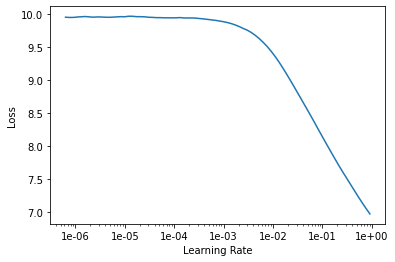

In [15]:
learn.lr_find()
learn.recorder.plot(skip_end=12)

In [16]:
learn.fit_one_cycle(1, 1e-3, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,9.604198,9.105647,0.036579,00:45


In [17]:
learn.unfreeze()
learn.fit_one_cycle(10, 7e-3, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,6.705754,5.157786,0.207171,01:00
1,5.645903,5.443115,0.183594,00:59
2,4.942555,3.168024,0.403153,01:01
3,4.213087,2.511163,0.497768,01:05
4,3.616786,2.144962,0.558677,01:05
5,3.119093,1.909367,0.604939,01:04
6,2.718846,1.768493,0.630497,01:06
7,2.393935,1.700967,0.645536,01:05
8,2.137962,1.666275,0.654520,01:05
9,1.942611,1.659620,0.655469,01:06


In [18]:
learn.predict('Kupite najbolji uređaj',  temperature=1.1, min_p=0.001, n_words=10)

'Kupite najbolji uređaj na tržištu besplatna dostava iznad kn isporuka odmah plaćanje do'

In [19]:
learn.save_encoder(MODELS/'campaign_encoder')

#### Prepare data set for training
Interaction rate (former CTR) and Impressions to numbers, drop all rows with few impr. or too high IR

In [20]:
df['Impr.'] = df['Impr.'].apply(lambda x: int(x.replace(',',''))) # Change Impressions to sum
df['Impr.'].sum() # Nr. of impressions, litle less then 27B

663165502

In [23]:
# Take percentage texts as sloats
df['Interaction rate'] = df['Interaction rate'].apply(lambda x: float(x.replace('%','').replace('--','0')))
df[df['Interaction rate'] > 25].shape[0]  # How much is over 25%, we're gonna drop that

9981

In [24]:
# Now let's delete all rows with no Impressions and Image ads
df = df.drop(df[(df['Impr.'] < 100) | (df['Interaction rate'] > 25)].index)
print(f'Number of rows for training: {df.shape[0]}')
df[:20]

Number of rows for training: 42340


,Ad status,Ad type,Final URL,Beacon URLs,Headline,Short headline,Long headline,Headline 1,Headline 1 position,Headline 2,...,Status,Impr.,Interactions,Interaction rate,Currency code,Avg. cost,Cost,Conversions,Cost / conv.,Conv. rate
221,Disabled,Expanded text ad,http://www.ekupi.hr/Blagdanski-pokloni-355155....,--,--,--,--,{KeyWord:Božićni ukrasi},--,Veliki izbor na jednom mjestu,...,Campaign paused,958,106,11.06,HRK,0.53,55.99,0.00,0.00,0.00%
426,Disabled,Text ad,NaN,--,eKupi igre za djevojčice,--,--,--,--,--,...,Campaign paused,1498,167,11.15,HRK,0.28,46.73,0.00,0.00,0.00%
522,Enabled,Expanded text ad,https://www.ekupi.hr/Late-night-shopping-g3772...,--,--,--,--,{Keyword:Usisavači},--,Late Night Shopping,...,Campaign paused,235,23,9.79,HRK,1.85,42.60,2.00,21.30,8.70%
778,Paused,Expanded text ad,http://www.ekupi.hr/Ploce-za-kuhanje-g34538.as...,--,--,--,--,Ploče za kuhanje,--,Više od 280 modela u prodaji,...,Campaign paused,119,11,9.24,HRK,1.39,15.26,0.00,0.00,0.00%
1016,Disabled,Text ad,NaN,--,eKupi igre za djevojčice,--,--,--,--,--,...,Campaign paused,249,12,4.82,HRK,0.18,2.19,0.00,0.00,0.00%
1180,Disabled,Text ad,NaN,--,{KeyWord:Tražite Playstation 4?},--,--,--,--,--,...,Removed,12139,785,6.47,HRK,1.20,945.09,1.00,945.09,0.13%
1332,Paused,Expanded text ad,http://www.ekupi.hr/Content/Search.aspx?qry=14...,--,--,--,--,Izaberi Gorenje Hladnjake,--,Na 24 rate,...,Campaign paused,240,32,13.33,HRK,1.28,41.09,0.00,0.00,0.00%
1419,Enabled,Responsive search ad,https://www.ekupi.hr/hr/search/?q=%22bu%C5%A1i...,--,--,--,--,{KeyWord: Bušilice - super ponuda},1,Plaćaj do 12 rata bez kamata,...,Approved,7559,443,5.86,HRK,0.72,318.37,7.22,44.12,1.63%
1423,Enabled,Responsive search ad,https://www.ekupi.hr/hr/search/?q=%22bu%C5%A1i...,--,--,--,--,{KeyWord: Bušilice - super ponuda},1,Plaćaj do 12 rata bez kamata,...,Approved,490,32,6.53,HRK,0.92,29.30,0.19,154.34,0.59%
1491,Enabled,Responsive search ad,https://www.ekupi.hr/hr/search/?q=%22bu%C5%A1i...,--,--,--,--,{KeyWord: Bušilice - super ponuda},1,Plaćaj do 12 rata bez kamata,...,Approved,9168,678,7.40,HRK,0.75,509.22,2.29,222.82,0.34%


#### Dataframes for training
Prepare and save dataframes with headlines and dascriptions for interaction regression

In [26]:
df_clean_headline = df.Headline.map(clean_text) + ' ' + df['Headline 1'].map(clean_text) + ' ' + df['Headline 2'].map(clean_text)  + ' ' + df['Headline 3'].map(clean_text) + ' ' +  df['Headline 4'].map(clean_text)+ ' '+ df['Headline 5'].map(clean_text)
df_clean_description = df.Description.map(clean_text) + ' '+ df['Description 1'].map(clean_text) + ' '+ df['Description 2'].map(clean_text)+ ' '+ df['Description 3'].map(clean_text)+ df['Description 4'].map(clean_text)+ ' '+ df['Description 5'].map(clean_text)
df_train_headline = pd.concat([df_clean_headline, df['Interaction rate']], axis= 1)
df_train_description = pd.concat([df_clean_description, df['Interaction rate']], axis= 1)
# Rename columns
df_train_headline.columns = ['text', 'rate']
df_train_description.columns = ['text', 'rate']

# Drop duplicates
df_train_headline.drop_duplicates(subset ="text", keep = 'first', inplace = True)

print(f'Number of different headline texts: {df_train_headline.shape[0]}')
df_train_description.drop_duplicates(subset ="text", keep = 'first', inplace = True)
print(f'Number of different description texts: {df_train_description.shape[0]}')
df_train_headline.to_csv(DATA/'headlines.csv', index=False)
df_train_headline.to_csv(DATA/'descriptions.csv', index=False)

Number of different headline texts: 4694
Number of different description texts: 5604


### Training regression

In [27]:

df_train = pd.read_csv(DATA/'headlines.csv')
df_train.head()

,text,rate
0,božićni ukrasi veliki izbor na jednom mjestu,11.06
1,igre za djevojčice,11.15
2,usisavači late night shopping,9.79
3,ploče za kuhanje više od modela u prodaji,9.24
4,tražite playstation,6.47


In [28]:
df_train.shape  # Lost lot of rows

(4694, 2)

In [29]:
# See possible approaches https://forums.fast.ai/t/regression-using-fine-tuned-language-model/29091/56
data_regr = (TextList.from_df(df=df_train, path=DATA, cols='text', vocab=data_lm.vocab)
             .split_by_rand_pct(0.2)
             .label_from_df('rate', label_cls=FloatList)
             .databunch(bs=bs))

/home/jovyan/.local/lib/python3.6/site-packages/fastai/core.py:302: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array(a, dtype=dtype, **kwargs)


/home/jovyan/.local/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


In [30]:
# Loss function - mse, optimizer - Adam ()-default, last layer - linear
learn = text_classifier_learner(data_regr, 
                                arch = AWD_LSTM, 
                                drop_mult=0.3,
                                metrics = rmse)
learn.loss_func = MSELossFlat()
learn.load_encoder(MODELS/'campaign_encoder')
learn.freeze()

/home/jovyan/.local/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/home/jovyan/.local/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the n

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


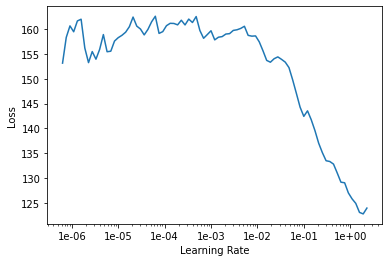

In [31]:
learn.lr_find()
learn.recorder.plot()

In [32]:
learn.fit_one_cycle(1, 6e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,root_mean_squared_error,time
0,109.811302,40.037647,6.288694,00:25


/home/jovyan/.local/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


In [33]:
learn.save(MODELS/'headline-first-run')

In [34]:
learn.load(MODELS/'headline-first-run')

RNNLearner(data=TextClasDataBunch;

Train: LabelList (3756 items)
x: TextList
xxbos božićni ukrasi veliki izbor na jednom mjestu,xxbos igre za djevojčice,xxbos usisavači late night shopping,xxbos tražite playstation,xxbos izaberi gorenje hladnjake na rate
y: FloatList
11.06,11.15,9.79,6.47,13.33
Path: /home/jovyan/work/data;

Valid: LabelList (938 items)
x: TextList
xxbos tražite najjeftinije gume na pravom ste mjestu dostavljamo besplatno,xxbos opremi svog školarca besplatna dostava iznad kn,xxbos hladnjaci online prodaja dodatnih popusta,xxbos hr provjeri našu online ponudu,xxbos candy perilice posuđa candy zna kako kupiti na rate
y: FloatList
20.4,0.12,6.03,5.33,9.76
Path: /home/jovyan/work/data;

Test: None, model=SequentialRNN(
  (0): MultiBatchEncoder(
    (module): AWD_LSTM(
      (encoder): Embedding(3056, 400, padding_idx=1)
      (encoder_dp): EmbeddingDropout(
        (emb): Embedding(3056, 400, padding_idx=1)
      )
      (rnns): ModuleList(
        (0): WeightDropout(
   

In [35]:
learn.freeze_to(-2)
learn.fit_one_cycle(1, slice(6e-2/(2.6**4),6e-1), moms=(0.8,0.7))

epoch,train_loss,valid_loss,root_mean_squared_error,time
0,59.651073,45.336666,6.691513,00:42


/home/jovyan/.local/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


In [36]:
# Save to possibly retrain again
learn.save(MODELS/'headline-second-run')
# Load again
learn.load(MODELS/'headline-second-run')
pass # don't show model definition again

In [37]:
learn.freeze_to(-3)
learn.fit_one_cycle(2, slice(1e-2/(2.6**4),1e-2), moms=(0.8,0.7))

epoch,train_loss,valid_loss,root_mean_squared_error,time
0,37.927895,34.976887,5.907223,00:58
1,36.270756,34.481323,5.868171,00:35


/home/jovyan/.local/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/home/jovyan/.local/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the n

In [38]:
# Save to possibly retrain again
learn.save(MODELS/'headline-third-run')
# Load again
learn.load(MODELS/'headline-third-run')
pass

In [39]:
learn.unfreeze()
learn.fit_one_cycle(3, slice(1e-2/(2.6**4),1e-2), moms=(0.8,0.7))

epoch,train_loss,valid_loss,root_mean_squared_error,time
0,34.339954,33.752140,5.789300,00:35
1,33.486359,40.929218,6.246308,00:34
2,31.420031,38.867989,6.122572,00:33


/home/jovyan/.local/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/home/jovyan/.local/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the n

In [40]:
learn.save(MODELS/'headline-final')

In [41]:
learn.predict("Kupi mobitel, najbolji popust")

(FloatItem [8.897916], tensor([8.8979]), tensor([8.8979]))

In [42]:
learn.export(MODELS/'headline-learner.pkl')